# Finding maxima using optimization

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.transforms as mtransforms
import os
from pyphonon import *

# Check for GPU support
try:
    import cupy as cp
    import numpy as np
    GPU = True
    print(bcolors.OKGREEN+'GPU Support Enabled'+bcolors.ENDC)
except ImportError:
    import numpy as np
    GPU = False
    print(bcolors.WARNING+'Cupy Not available in your system. No GPU Support'+bcolors.ENDC)

# Ignore large warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Set some flags and environment variables
data_dir     = './data/'
fluid_dir    = 'fluids/'
particle_dir = 'particles/'

%matplotlib widget

CUDA GPU Acceleration is unavailable for your system : (
Cupy Not available in your system. No GPU Support


In [2]:
# Create an estimator

# Simulator parameters
max_order   = 1
n_cores     = 20
slow        = False

# Create estimator
E = estimator(max_order=max_order,n_cores=n_cores,slow=slow,GPU=GPU)

Generating Estimator for order 1
Assembling the estimator using multiprocessing on 20 cores
Permuations created successfully
	Send the fast data to the pool
CUDA GPU Acceleration is unavailable for your system : (
CUDA GPU Acceleration is unavailable for your system : (
CUDA GPU Acceleration is unavailable for your system : (
	Fast: 0, 0 Done!
	Fast: 1, 0 Done!
	Fast: 1, 1 Done!
Pool closed Successfully
recasting functions


  0%|          | 0/3 [00:00<?, ?it/s]

Estimator Generated Successfully


In [3]:
# # Simulation parameters
# r   = 0.5
# z   = 1.2
# # t   = 
# v   = 1.5
# l   = 0.

# # Estimator caller
# p = lambda x: -E(r,x[1],x[0],v,l)

# # Jacobian
# JAC = E.get_jacobian()
# jac = lambda x: -JAC(r,x[1],x[0],v,l)

# # Define optimization constraints
# constraints_ineq = {
#     'type': 'ineq',
#     'fun':  lambda x: np.array([-x[1] - r*np.sqrt(v**2-1) + v*x[0]]),
#     'jac':  lambda x: np.array([v,-1]),
# }

# constraints_eq ={
#     'type': 'eq',
#     'fun':  lambda x: np.array([x[0]**2 + r**2/(1-v**2)]),
#     'jac':  lambda x: np.array([2*x[0],0])
# }

# # res = minimize(p,x0,method='SLSQP',jac=jac,
# #                 constraints=[constraints_ineq],options={'ftol': 1e-9, 'disp': True})

# # Do the optimization
# x0 = np.array([np.sqrt(r**2 + z**2),0])
# res = minimize(p,x0,method='nelder-mead',
#                 options={'xatol': 1e-10, 'disp': True})
# print(res)

In [8]:
# Calculate the maximum pressure given certain parameters
def max_pressure(r,v,l):
    # Initial token z position
    z   = 0.1

    # Estimator caller
    p = lambda x: -E(r,x[1],x[0],v,l)

    # Do the optimization
    x0 = np.array([np.sqrt(r**2 + z**2),0])
    res = minimize(p,x0,method='nelder-mead', options={'xatol': 1e-9, 'disp': True})

    return -res['fun'], res['x'], res

# Calculate the maximum pressure given certain parameters and constraints
def max_pressure_constrained(r,v,l):
    # Initial token z position
    z   = 0.1

    # Define constraints
    const   = lambda x: np.array([x[0] - np.sqrt(r**2 + x[1]**2)])
    jac     = lambda x: np.array([1,-x[1]/np.sqrt(r**2 + x[1]**2)])
    hess    = lambda x,v: v[0]*np.array([0,0]) + v[1]*np.array([0,-r**2/np.sqrt(r**2+z**2)**3])
    
    constraint = NonlinearConstraint(const,0,np.inf,jac=jac,hess=hess)

    # Get jacobian and hessian estimator
    print('Generating Jacobian')
    JAC     = E.get_jacobian()
    print('Generating Hessian')
    HES     = E.get_hessian()

    # Estimator caller
    p = lambda x: -E(r,x[1],x[0],v,l)

    # Do the optimization
    print('Starting Optimization')
    x0 = np.array([np.sqrt(r**2 + z**2),0])
    res = minimize(p,x0,method='trust-constr', jac=JAC, hes=HES, 
                    constraints=[constraint], options={'verbose': 1,'xatol': 1e-9, 'disp': True})

    return -res['fun'], res['x'], res

# Plot the maximum
def plot_max(r,z,t,v,l,tol=0.01,Npts=10000):
    # Create a figure
    fig = plt.figure()
    ax  = fig.add_subplot(111)
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

    # Get the time and plot everything
    T   = np.linspace(t-tol,t+tol,Npts)
    ax.plot(T,E(r,z,T,v,l))
    ax.axvline(t,c='k')
    ax.fill_between(T,0,1,v*T - (z+r*np.sqrt(v**2-1)) < 0,facecolor='red',alpha=0.1,transform=trans)

    return fig,ax

In [9]:
# Collect the fluids and particles from the directories
fluid_files     = [data_dir+fluid_dir+f for f in os.listdir(data_dir+fluid_dir)]
fluid_names     = [f.replace('.txt','') for f in os.listdir(data_dir+fluid_dir)]
particle_files  = [data_dir+particle_dir+f for f in os.listdir(data_dir+particle_dir)]
particle_names  = [f.replace('.txt','') for f in os.listdir(data_dir+particle_dir)]
fluids          = [fluid(fname,name=n) for fname,n in zip(fluid_files,fluid_names)] 
particles       = [particle(fname,name=n) for fname,n in zip(particle_files,particle_names)]

Optimization terminated successfully.
         Current function value: -168889659955085197185710115801110937600.000000
         Iterations: 142
         Function evaluations: 313
 final_simplex: (array([[9.95014844e-01, 2.74067266e-04],
       [9.95014844e-01, 2.74067266e-04],
       [9.95014844e-01, 2.74067266e-04]]), array([-1.6888966e+38, -1.6888966e+38, -1.6888966e+38]))
           fun: -1.688896599550852e+38
       message: 'Optimization terminated successfully.'
          nfev: 313
           nit: 142
        status: 0
       success: True
             x: array([9.95014844e-01, 2.74067266e-04])


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

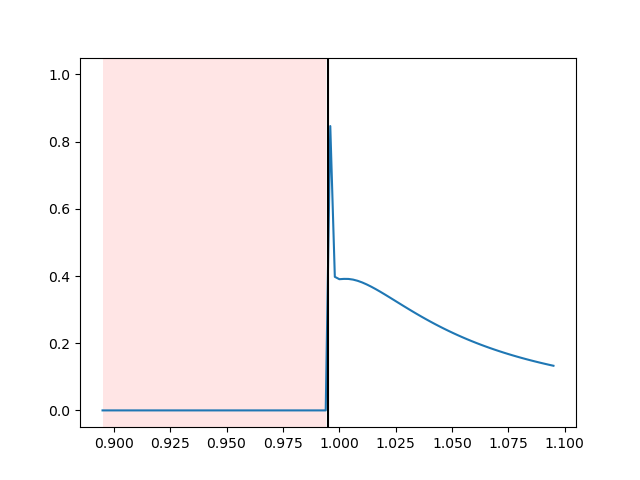

In [10]:
muon    = particles[0]
xe      = fluids[3]

muon(10*xe.sound_speed)
r = 100e-2
v = muon.speed/xe.sound_speed
l = xe.viscosity_coefficient()*xe.sound_speed

fun,x,res = max_pressure(r,v,l)
print(res)
plot_max(r,x[1],x[0],v,l,tol=.1,Npts=100)

In [11]:
muon    = particles[0]
xe      = fluids[3]

muon(10*xe.sound_speed)
r = 100e-2
v = muon.speed/xe.sound_speed
l = xe.viscosity_coefficient()*xe.sound_speed

fun,x,res = max_pressure_constrained(r,v,l)
print(res)
plot_max(r,x[1],x[0],v,l,tol=.1,Npts=100)

Generating Jacobian
Generating Hessian


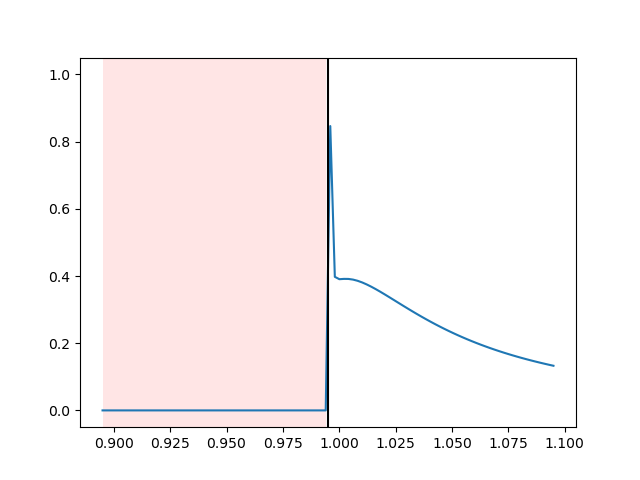

In [ ]:
r = 100e-2
v = muon.speed/xe.sound_speed
l = xe.viscosity_coefficient()*xe.sound_speed

fig,ax = plot_max(r,x[1],x[0],v,l,tol=.1,Npts=100)

In [ ]:
ax.axvline(np.sqrt(r**2 + x[1]**2),c='g')